# Visualizing DJIA .csv File

In [58]:
# Import required libraries

import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.dates as mdates
from wordcloud import WordCloud
import re
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pio
from IPython.display import Image
import yfinance as yf
from tensorflow.random import set_seed
from datetime import datetime
import math
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from numpy.polynomial.polynomial import Polynomial
from sklearn.metrics import mean_squared_error

### Load Input

In [59]:
# # DJIA_table.csv has 1989 rows

# df = pd.read_csv('./upload_DJIA_table.csv', delimiter=',')
# df.dataframeName = 'DJIA_table.csv'
# nRow, nCol = df.shape
# print(f'There are {nRow} rows and {nCol} columns')

import warnings
warnings.simplefilter("ignore")

set_seed(455)
np.random.seed(455)

In [60]:
start = datetime(2017, 12, 16)
end = datetime(2020, 7, 18)
df = yf.download("^DJI", start, end)
df.reset_index(inplace=True)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-18,24739.560547,24876.070312,24739.560547,24792.199219,24792.199219,354880000
1,2017-12-19,24834.380859,24850.109375,24715.599609,24754.750000,24754.750000,335330000
2,2017-12-20,24838.089844,24852.439453,24697.109375,24726.650391,24726.650391,341790000
3,2017-12-21,24778.259766,24850.910156,24766.269531,24782.289062,24782.289062,339530000
4,2017-12-22,24764.039062,24784.150391,24717.509766,24754.060547,24754.060547,255140000


In [61]:
# df = df.sort_values(by=['Date'])
# df['Date'] = pd.to_datetime(df['Date'])

# df.head()

In [62]:
# reddit_news = pd.read_csv('./RedditNews.csv', delimiter=',')
# combined_news = pd.read_csv('./Combined_News_DJIA.csv', delimiter=',')
financial_news = pd.read_csv('./Financial_News_Cleaned.csv', delimiter=',')
news_sentiment = pd.read_csv('./Financial_News_Sentiment.csv', delimiter=',')

news_sentiment['Date'] = pd.to_datetime(news_sentiment['Date'])
dates_to_remove = ['2023-07-18', '2023-04-18']
dates_to_remove = pd.to_datetime(dates_to_remove)
news_sentiment = news_sentiment[~news_sentiment['Date'].isin(dates_to_remove)]
news_sentiment = news_sentiment.sort_values(by=['Date'])

### Helper Functions

In [63]:
# Distribution graphs (histogram/bar graph) of column data

def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) // nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
            if i == 0 and np.issubdtype(columnDf.dtype, np.number):
                start_year = int(columnDf.min())
                end_year = int(columnDf.max()) + 1
                plt.xticks(range(start_year, end_year))
                
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()
    

In [64]:
# Correlation matrix

def plotCorrelationMatrix(df, graphWidth):
    #filename = df.dataframeName
    numeric_columns = df.select_dtypes(include=[np.number])
    #df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = numeric_columns.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for DJIA', fontsize=15)
    plt.show()

In [65]:
# Scatter and density plots

def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna(axis = 'columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [66]:
def plotClosingMovingPriceOverTime(df):
    plt.figure(figsize=(12, 6))
    df['10_day_MA'] = df['Adj Close'].rolling(window=10).mean()
    plt.plot(df['Date'], df['Adj Close'], label='Adjusted Closing Price')
    plt.plot(df['Date'], df['10_day_MA'], label='10-Day Moving Average', color='orange')
    
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6)) 
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 

    plt.title('DJIA Adjusted Closing Price Over Time & Bieekly Moving Average')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Closing Price')
    plt.xticks(rotation=45)
    plt.legend()

    plt.show()

In [67]:
def plotBubbleChartBiweekly(df):
    df.set_index('Date', inplace=True)

    biweekly_df = df.resample('2W').mean().reset_index()

    plt.figure(figsize=(12, 6))
    plt.scatter(biweekly_df['Date'], biweekly_df['Adj Close'], s=biweekly_df['Volume']/1000000, alpha=0.5)

    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6)) 
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 

    plt.title('DJIA Biweekly Average Trading Volume (in millions) vs Adjusted Closing Price')
    plt.xlabel('Date')
    plt.ylabel('Average Adjusted Closing Price')
    plt.xticks(rotation=45)
    plt.show()

    df.reset_index(inplace=True)


In [68]:
def plotNewsWordCloud(financial_news):
    words_to_exclude = []

    financial_news_all_text = " ".join([str(headline) for headline in financial_news['Headlines']])
    processed_financial_news_all_text = " ".join([word for word in financial_news_all_text.split() if len(word) > 1 and word.lower() not in [item.lower() for item in words_to_exclude]])
    financial_news_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(processed_financial_news_all_text)

    plt.figure(figsize = (10, 10), facecolor = None) 
    plt.imshow(financial_news_wordcloud, interpolation="bilinear")
    plt.title('Financial News Word Cloud')
    plt.axis("off")
    plt.show()

    plt.show()

In [69]:
def plotRelativeVolumeHeatmap(df):
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month

    #Calculate the mean trading volume for each year
    #yearly_mean_volume = df.groupby('Year')['Volume'].transform('mean')

    #Calculate the relative trading volume by dividing the actual volume by the yearly mean
    #df['Relative_Volume'] = df['Volume']/yearly_mean_volume

    pivot_table = df.pivot_table(values='Volume', index='Month', columns='Year')

    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot_table, cmap='inferno', annot=False, fmt=".2f", cbar_kws={'label': 'Volume'})
    plt.gca().invert_yaxis()
    plt.title('Relative Yearly Trading Volume Heatmap')
    plt.xlabel('Year')
    plt.ylabel('Month')
    plt.show()


In [70]:
def plotCandlestick():
    pio.renderers.default = "browser"

    fig = go.Figure(data=[go.Candlestick(
                    x=df['Date'],
                    open=df['Open'],
                    high=df['High'],
                    low=df['Low'],
                    close=df['Close'])])

    fig.update_layout(title='Candlestick Chart DJIA', xaxis_title='Date', yaxis_title='Price')
    fig.show()

In [71]:
def plotNewsSentimentOverTime(news_sentiment):
    plt.figure(figsize=(12, 6))
    plt.plot(news_sentiment['Date'], news_sentiment['Positive'], label='Positive Sentiment', color='green')
    plt.plot(news_sentiment['Date'], news_sentiment['Neutral'], label='Neutral Sentiment', color='orange')
    plt.plot(news_sentiment['Date'], news_sentiment['Negative'], label='Negative Sentiment', color='red')
    plt.title('Financial News Sentiment Over Time')
    plt.xlabel('Date')
    plt.ylabel('Sentiment Score')
    plt.legend()
    plt.show()

In [86]:
def plotBiweeklyNewsSentimentOverTime(news_sentiment):
    news_sentiment.set_index('Date', inplace=True)
    biweekly_sentiment = news_sentiment.resample('2W').mean()
    news_sentiment.reset_index(inplace=True)
    biweekly_sentiment.reset_index(inplace=True)

    df.set_index('Date', inplace=True)
    biweekly_df = df.resample('2W').mean()
    df.reset_index(inplace=True)
    biweekly_df.reset_index(inplace=True)

    plt.figure(figsize=(12, 6))
    plt.plot(biweekly_sentiment['Date'], biweekly_sentiment['Positive']*35000, label='Positive Sentiment', color='green', linestyle='--')
    plt.plot(biweekly_sentiment['Date'], biweekly_sentiment['Neutral']*35000, label='Neutral Sentiment', color='orange', linestyle='--')
    plt.plot(biweekly_sentiment['Date'], biweekly_sentiment['Negative']*35000, label='Negative Sentiment', color='red', linestyle='--')
    plt.plot(biweekly_df['Date'], biweekly_df['Close'], label='DJIA Close', color='blue')
    plt.title('Biweekly Financial News Sentiment vs Biweekly Closing Prices Over Time')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()

In [73]:
def NegativeSentimentvsClosing(news_sentiment):
    # Merge the DataFrames on the 'Date' column
    merged_df = pd.merge(df, news_sentiment, on='Date')

    # Plotting Volume vs Positive Sentiment
    plt.figure(figsize=(12, 6))
    plt.scatter(merged_df['Negative'], merged_df['Close'], alpha=0.5, color='red')
    plt.title('DJIA Negative Sentiment vs Closing Price')
    plt.xlabel('Negative Sentiment Score')
    plt.ylabel('Closing Price')
    plt.show()


### Visualizations

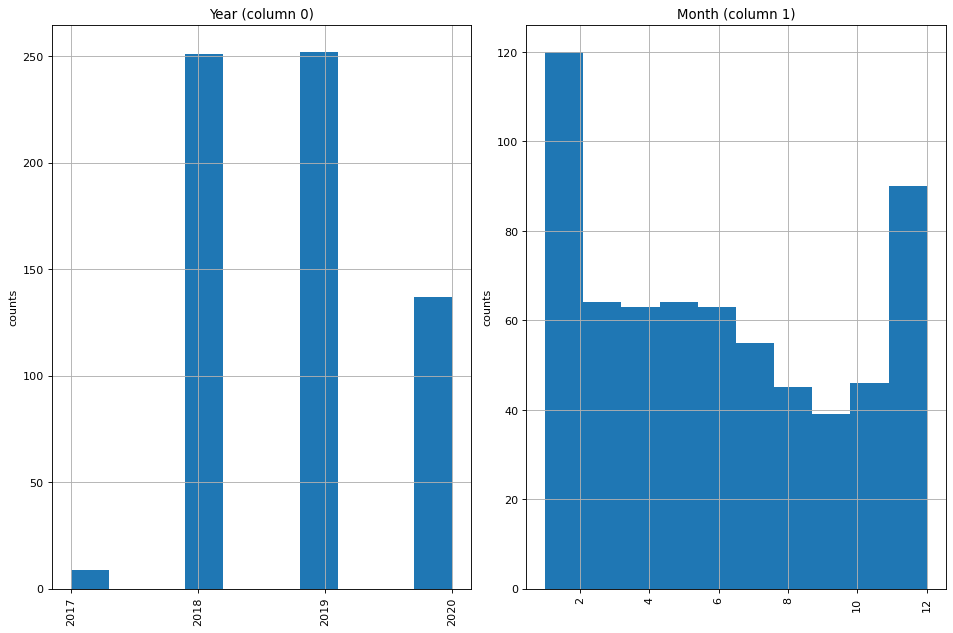

In [85]:
plotPerColumnDistribution(df, 2, 2)

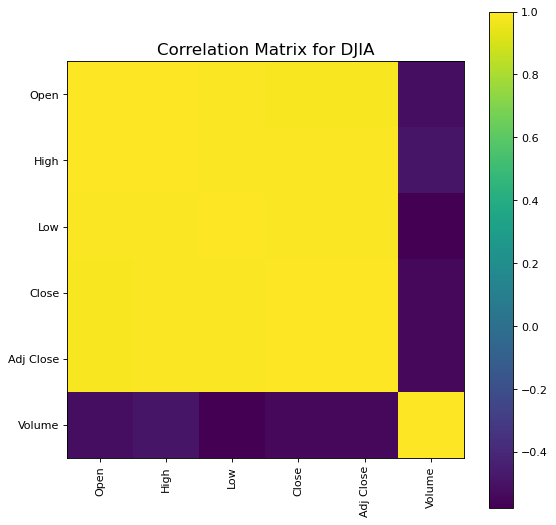

In [75]:
plotCorrelationMatrix(df, 8)

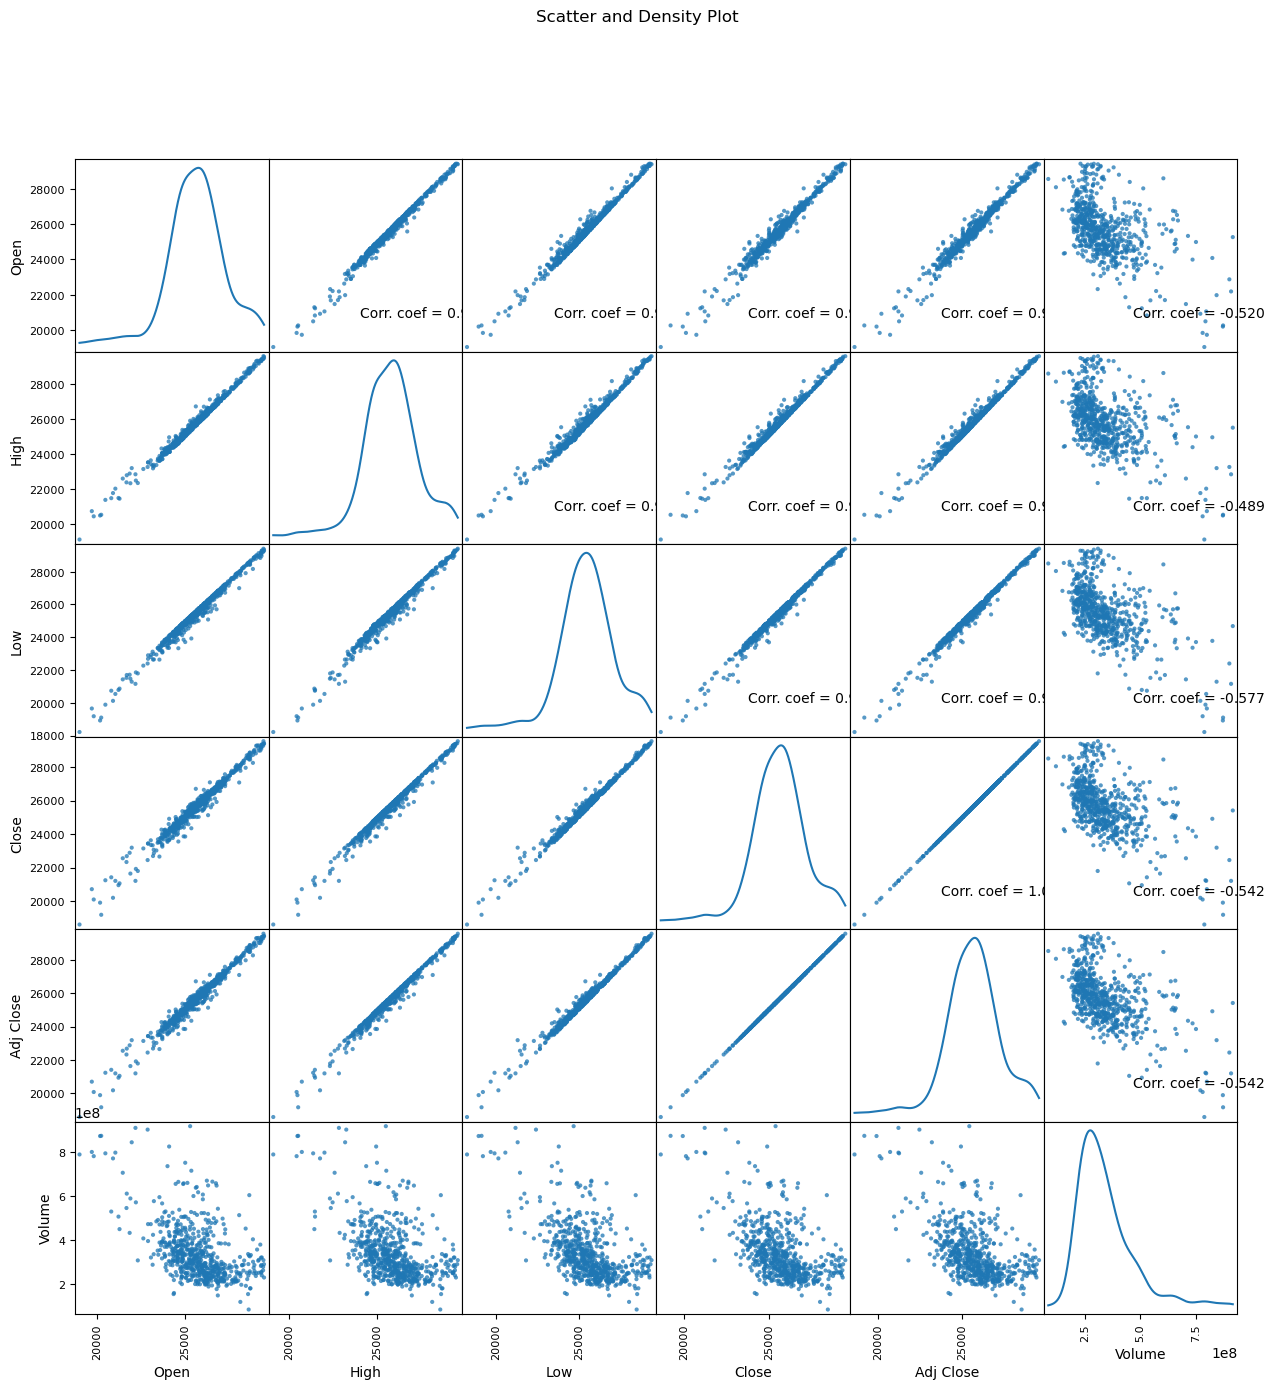

In [76]:
plotScatterMatrix(df, 15, 10)

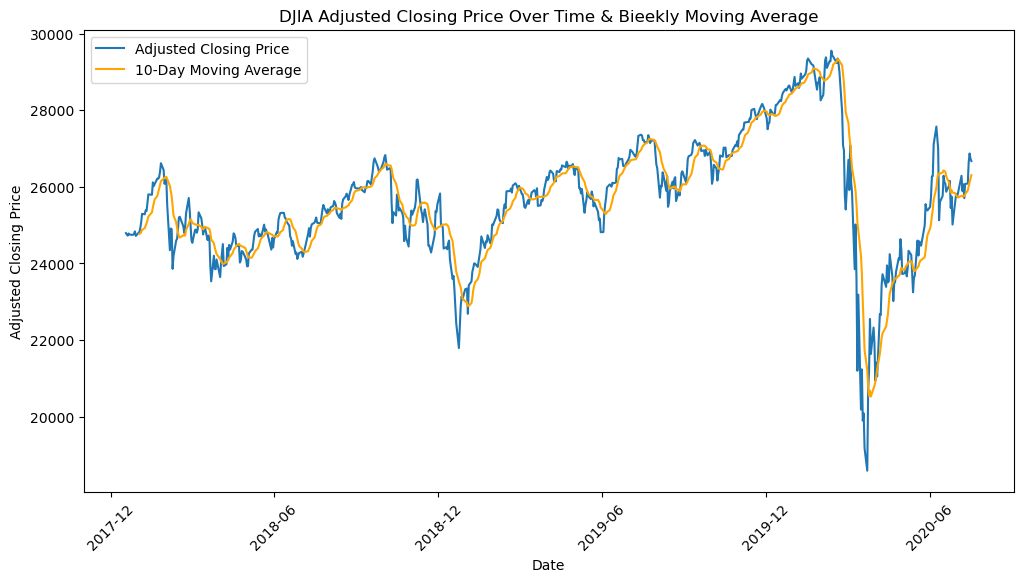

In [77]:
plotClosingMovingPriceOverTime(df)

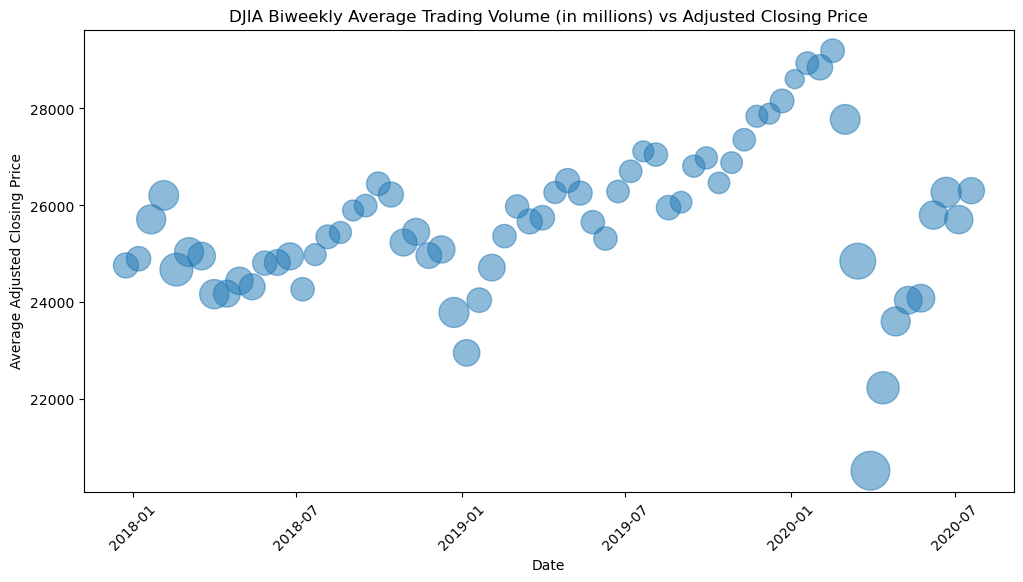

In [78]:
plotBubbleChartBiweekly(df)

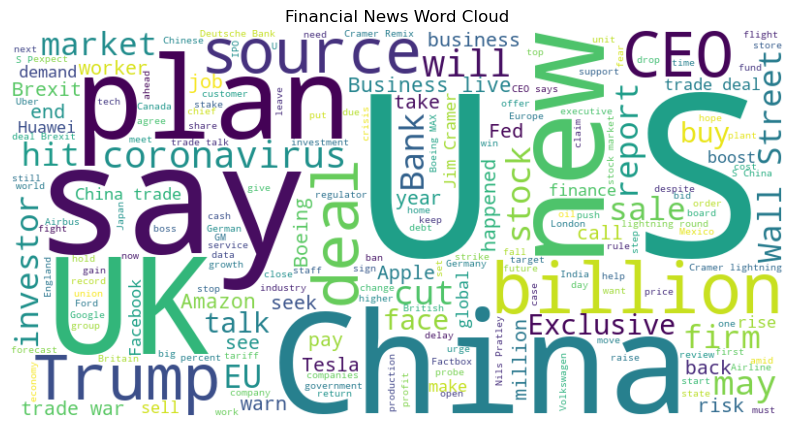

In [79]:
plotNewsWordCloud(financial_news=financial_news)

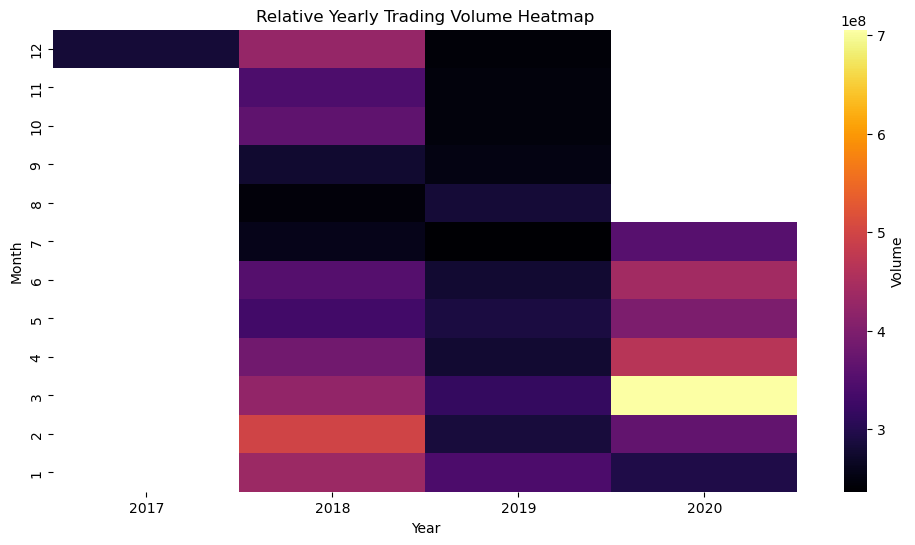

In [80]:
plotRelativeVolumeHeatmap(df)

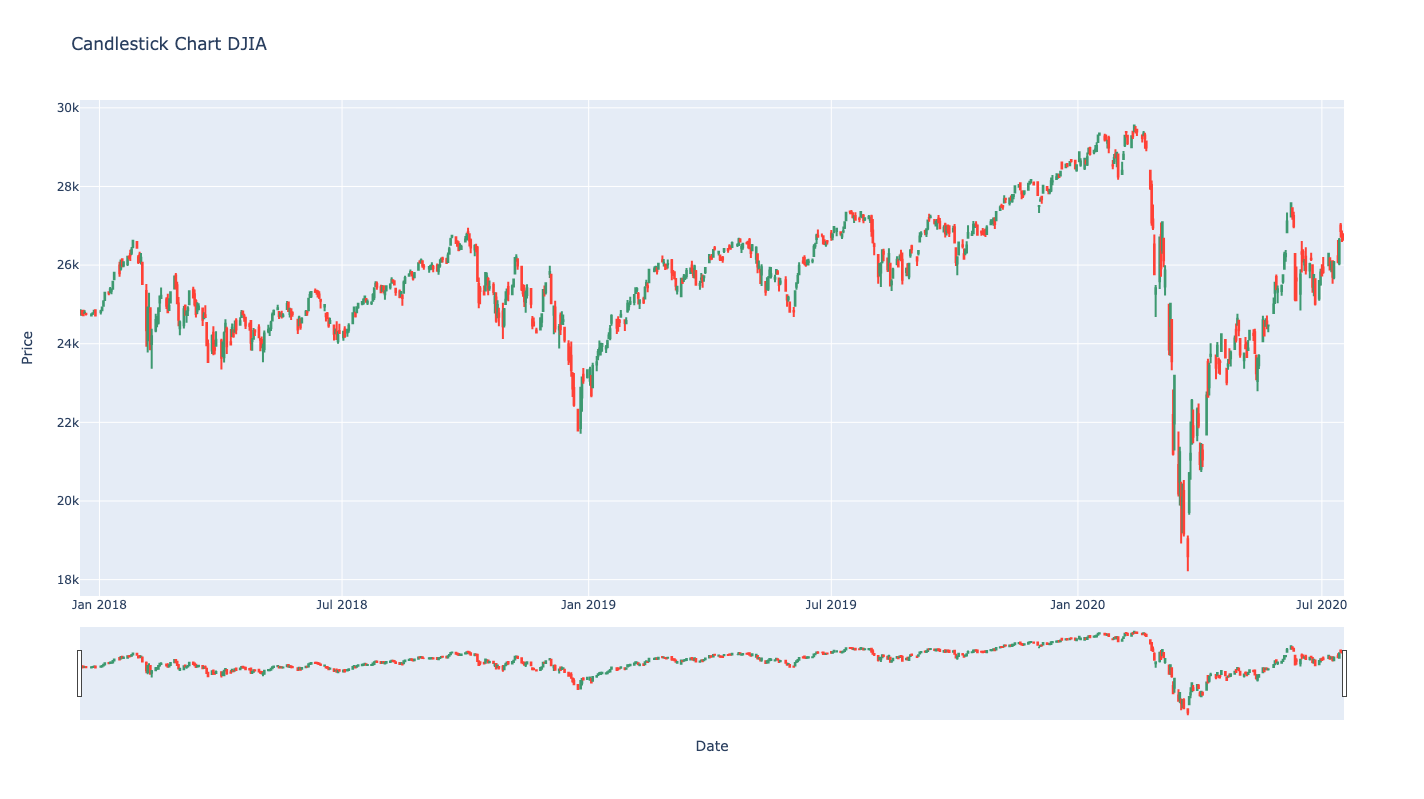

In [81]:
#Run this cell to get the interactive candlestick chart on your browse
plotCandlestick()

#This is how the chart looks like
image_path = 'candlestick.png'
Image(filename=image_path)

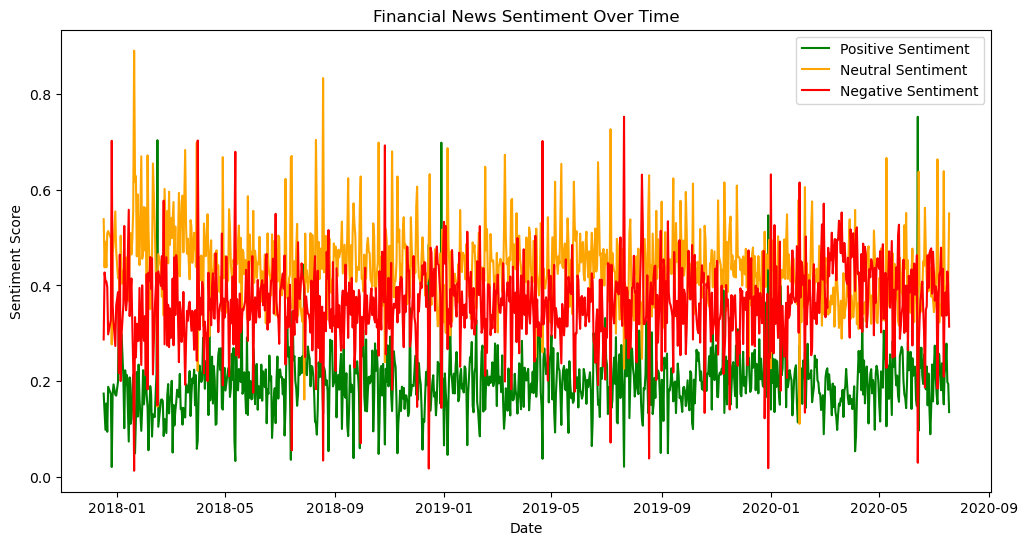

In [82]:
plotNewsSentimentOverTime(news_sentiment)

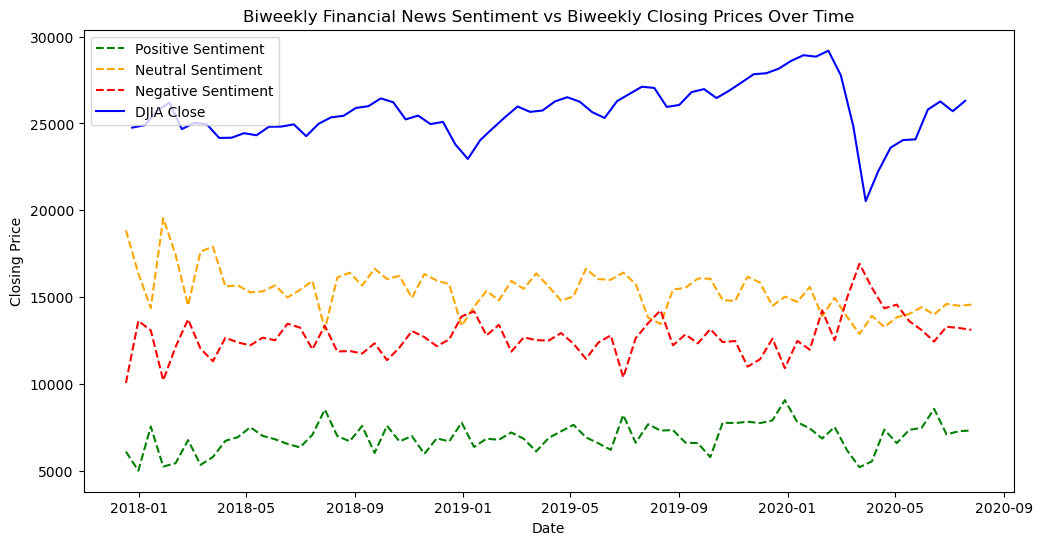

In [87]:
plotBiweeklyNewsSentimentOverTime(news_sentiment)

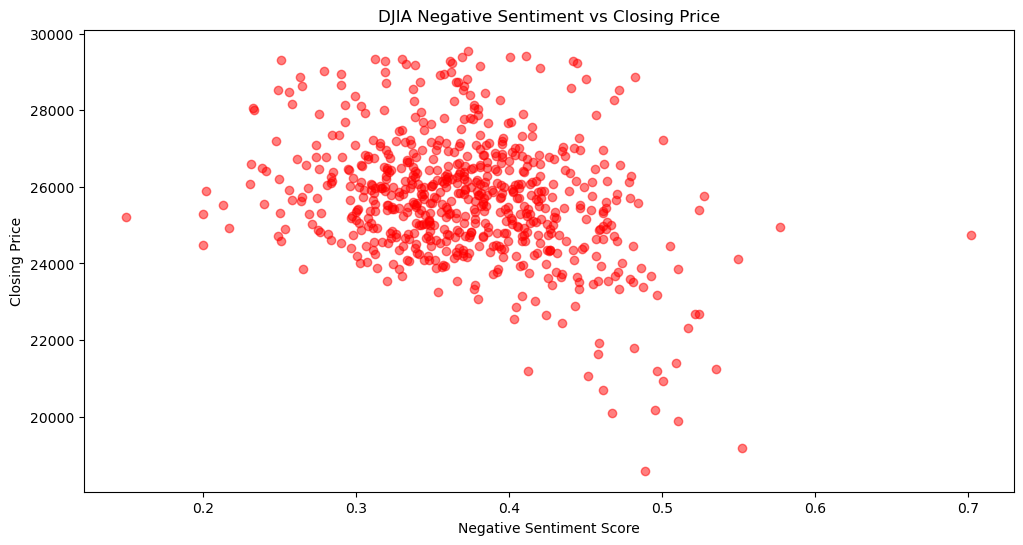

In [84]:
NegativeSentimentvsClosing(news_sentiment)